## Figures & Statistics for the Paper:
# Fast Portfolio Diversification

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/FinanceOps) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmlHaWuVxIA0pKL1yjryR0Z)

## Introduction

This Python Notebook produces the plots and statistics used in the paper entitled **"Fast Portfolio Diversification"** which can be downloaded from [SSRN](http://papers.ssrn.com/sol3/cf_dev/AbsByAuth.cfm?per_id=1993051) and [GitHub](https://github.com/Hvass-Labs/Finance-Papers).

See the [GitHub repository](https://github.com/Hvass-Labs/FinanceOps) for instructions on how to install and run this Python Notebook. The Python source-code is well-documented so you can hopefully understand and modify it yourself, but there is otherwise a minimum of explanations in this Notebook because it is all explained in the paper.

## Python Imports

This Jupyter Notebook is implemented in Python v. 3.8 and requires various packages for numerical computations and plotting. See the installation instructions in the README-file.

In [1]:
%matplotlib inline

In [2]:
# Imports from Python packages.
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import pandas as pd
import numpy as np
import numba as nb
import os
from time import time
from numba import jit

In [3]:
# InvestOps for DENSE correlation matrix.
import investops as iv
from investops.diversify import diversify_weights
from investops.random import rand_weights_normal, rand_corr_normal, rand_zero
from investops.check import fix_corr_matrix

In [4]:
# InvestOps for SPARSE correlation matrix.
from investops.diversify_sparse import diversify_weights_sparse
from investops.sparse import matrix_to_sparse

## Config

In [5]:
# Random number generator.
# The seed makes the experiments repeatable.
rng = np.random.default_rng(seed=80085)

In [6]:
# Create directory for plots if it does not exist already.
path_plots = 'plots/fast_portfolio/'
if not os.path.exists(path_plots):
    os.makedirs(path_plots)

In [7]:
# Matplotlib settings.
# Used to format numbers on plot-axis as percentages.
pct_formatter0 = FuncFormatter(lambda x, _: '{:.0%}'.format(x))

In [8]:
# Seaborn set plotting style.
sns.set_style("whitegrid")

In [9]:
# Plot-sizes.
figsize_small = (10, 4)
figsize_mid = (10, 8)
figsize_big = (10, 12)

## Comparison of Time-Usage

Perform thousands of trials with random portfolio weights and correlation matrices, to compare the time-usage of the following variations of the diversification algorithm:

- DENSE correlation matrix, SERIAL execution.
- DENSE correlation matrix, PARALLEL execution.
- SPARSE correlation matrix, SERIAL execution.

In [10]:
def rand_weights_corr(num_assets, sparsity, weight_std=0.05, corr_std=0.4):
    """
    Generate random portfolio weights and correlation matrix.
    
    :param num_assets:
        Integer with the number of assets in the portfolio.
        
    :param sparsity:
        Float between 0 and 1 with sparsity of corr. matrix.
        
    :param weight_std:
        Float with std.dev. for the normal-dist. random weights.
        
    :param corr_std:
        Float with std.dev. for the normal-dist. corr. matrix.
        
    :return:
        weights_org: Numpy array with random portfolio weights.
        corr_dense: Numpy 2-dim array with corr. matrix.
        corr_i: Numpy array with row-coordinates for sparse corr. matrix.
        corr_j: Numpy array with col-coordinates for sparse corr. matrix.
        corr_coef: Numpy array with coefficients for sparse corr. matrix.
    """
    # Generate random portfolio weights.
    weights_org = rand_weights_normal(rng=rng, num_assets=num_assets,
                                      min_weight=-1.0, max_weight=1.0,
                                      std=weight_std)

    # Generate random correlation matrix.
    corr_dense = rand_corr_normal(rng=rng, num_assets=num_assets, std=corr_std)

    # Randomly set some of the matrix to zero.
    corr_dense = rand_zero(rng=rng, a=corr_dense, prob=sparsity)

    # Make the correlation matrix symmetrical again.
    corr_dense += corr_dense.T

    # Ensure it is a valid correlation matrix.
    fix_corr_matrix(corr=corr_dense, copy=False)

    # Only use the upper-triangle of the correlation matrix, otherwise
    # the sparse algorithm would use the correlations twice.
    corr_dense_triu = np.triu(corr_dense, k=1)

    # Convert to a sparse matrix in Coordinate (COO) format.
    corr_i, corr_j, corr_coef = matrix_to_sparse(mat=corr_dense_triu)
    
    return weights_org, corr_dense, corr_i, corr_j, corr_coef

In [11]:
# Use the diversification functions once to compile with Numba Jit,
# otherwise it would distort the timing tests below.

# Random portfolio weights and correlations.
weights_org, corr_dense, corr_i, corr_j, corr_coef = \
    rand_weights_corr(num_assets=100, sparsity=0.9,
                      weight_std=0.05, corr_std=0.4)

# DENSE diversification algorithm.
diversify_weights(weights_org=weights_org, corr=corr_dense);

# SPARSE diversification algorithm.
diversify_weights_sparse(weights_org=weights_org,
    corr_i=corr_i, corr_j=corr_j, corr_coef=corr_coef);

In [12]:
# Names used in log of results.
NUM_ASSETS = 'Num Assets'
SPARSITY = 'Sparsity'
METHOD = 'Diversify Method'
SPARSE = 'Sparse'
DENSE_PAR = 'Dense Parallel'
DENSE_SER = 'Dense Serial'
TIME = 'Time / msec'
MAX_ABS_DIF = 'Max Abs Dif'
NUM_TRIALS = 'Num Trials'

In [13]:
def log_append(method, num_assets, sparsity,
               max_abs_dif, start_time, end_time):
    """
    Append the results to the log.
    
    :param method: String with method name.
    :param num_assets: Int with number of portfolio assets.
    :param sparsity: Float with sparsity of corr. matrix.
    :param max_abs_dif:
        Float with max abs. diff. between the weights from
        this method and the DENSE / SERIAL algorithm.
    :param start_time: Float with start-time.
    :param end_time: Float with end-time.
    :return: None
    """
    log_data = \
    {
        NUM_ASSETS: num_assets,
        SPARSITY: sparsity,
        METHOD: method,
        TIME: (end_time - start_time) * 1000,
        MAX_ABS_DIF: max_abs_dif,
    }
    log.append(log_data)

In [14]:
# Number of assets in each random portfolio.
num_assets = [50, 100, 200, 500, 1000, 2000]

# Min / max number of trials for each portfolio size.
min_trials = 10
max_trials = 100

In [15]:
%%time
# Initialize log with results.
log = []

# For each portfolio size.
for n in num_assets:
    # For each choice of sparsity for corr. matrix.
    for sparsity in np.arange(0, 1, 0.05):
        # Initialize sum of time-usage.
        sum_time = 0

        # Initialize number of random trials performed.
        num_trials = 0

        # Repeat until enough random trials have been performed.
        while num_trials < max_trials:
            # Print status.
            print(f'n={n}, sparsity={sparsity:.2f}', end='\r')

            # Generate random portfolio weights and correlations.
            weights_org, corr_dense, corr_i, corr_j, corr_coef = \
                rand_weights_corr(num_assets=n, sparsity=sparsity,
                                  weight_std=0.05, corr_std=0.4)

            # DENSE / SERIAL Diversification Algorithm.
            start_time = time()
            weights_new_dense_ser = \
                diversify_weights(weights_org=weights_org, corr=corr_dense,
                                  parallel=False)
            end_time = time()
            sum_time += end_time - start_time
            log_append(method=DENSE_SER, num_assets=n,
                       sparsity=sparsity, max_abs_dif=None,
                       start_time=start_time, end_time=end_time)

            # DENSE / PARALLEL Diversification Algorithm.
            start_time = time()
            weights_new_dense_par = \
                diversify_weights(weights_org=weights_org, corr=corr_dense,
                                  parallel=True)
            end_time = time()
            sum_time += end_time - start_time
            max_abs_dif = np.max(np.abs(weights_new_dense_ser - weights_new_dense_par))
            log_append(method=DENSE_PAR, num_assets=n,
                       sparsity=sparsity, max_abs_dif=max_abs_dif,
                       start_time=start_time, end_time=end_time)

            # SPARSE / SERIAL Diversification Algorithm.
            start_time = time()
            weights_new_sparse = \
                diversify_weights_sparse(weights_org=weights_org,
                    corr_i=corr_i, corr_j=corr_j, corr_coef=corr_coef)
            end_time = time()
            sum_time += end_time - start_time
            max_abs_dif = np.max(np.abs(weights_new_dense_ser - weights_new_sparse))
            log_append(method=SPARSE, num_assets=n,
                       sparsity=sparsity, max_abs_dif=max_abs_dif,
                       start_time=start_time, end_time=end_time)
            
            # Increase number of trials performed.
            num_trials += 1

            # Break out of for-loop if spent more than 1 second.
            if num_trials > min_trials and sum_time > 1:
                break

# Convert log to Pandas DataFrame.
df_log = pd.DataFrame(log)

# Show the first rows of the log.
df_log.head()

CPU times: user 3min 41s, sys: 7.67 s, total: 3min 49s
Wall time: 2min 47s


,Num Assets,Sparsity,Diversify Method,Time / msec,Max Abs Dif
0,50,0.0,Dense Serial,0.124693,NaN
1,50,0.0,Dense Parallel,0.361443,0.000000e+00
2,50,0.0,Sparse,0.197172,3.469447e-18
3,50,0.0,Dense Serial,0.139236,NaN
4,50,0.0,Dense Parallel,0.214815,0.000000e+00


In [16]:
# Show statistics for the number of trials per combination of:
# method, num_assets, and sparsity.
df_log.groupby([METHOD, NUM_ASSETS, SPARSITY]).apply(lambda df: len(df)).describe()

count    360.000000
mean      68.333333
std       38.676791
min       11.000000
25%       18.000000
50%      100.000000
75%      100.000000
max      100.000000
dtype: float64

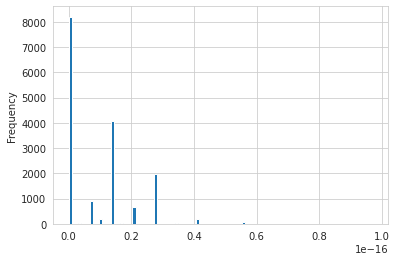

In [17]:
# Histogram of the Max Abs. Difference.
# This shows that there is a tiny difference between the
# weights created by the different versions of the algorithm.
# The tiny difference is likely just due to float rounding errors.
df_log[MAX_ABS_DIF].plot(kind='hist', bins=100);

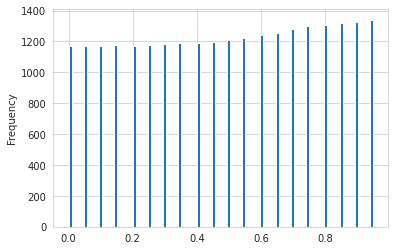

In [18]:
# Histogram of the sparsity versus the number of trials.
df_log[SPARSITY].plot(kind='hist', bins=100);

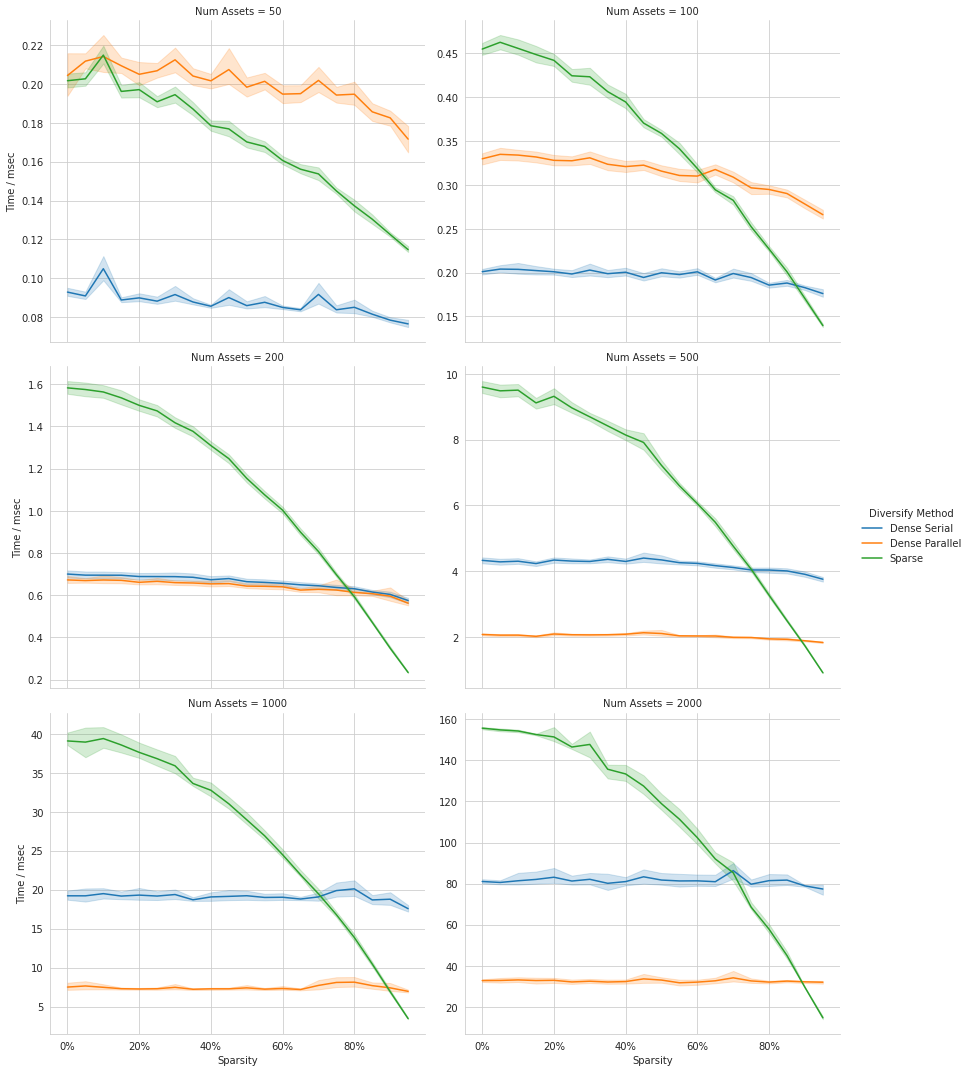

In [19]:
# Plot comparison of the time-usage.
g = sns.relplot(kind='line', data=df_log, x=SPARSITY, y=TIME,
                col=NUM_ASSETS, hue=METHOD, col_wrap=2,
                facet_kws=dict(sharey=False), ci=99,
                height=5, aspect=6/5);

# Adjust padding.
g.tight_layout()

# For all sub-plots.
for ax in g.axes:
    # Show x-axis as percentages.
    ax.xaxis.set_major_formatter(pct_formatter0)

# Save plot to a file.
filename = 'Time-Usage Comparison.svg'
filename = os.path.join(path_plots, filename)
g.savefig(filename, bbox_inches='tight')

## License (MIT)

Copyright (c) 2022 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.